# Open-source LLM's as Agents with `ChatHuggingFace`


Open source LLMs are becoming viable general purpose agents. The goal of this notebook is to demonstrate how to make use of open-source LLMs as chat models using [Hugging Face Inference Endpoints](https://huggingface.co/docs/inference-endpoints/index) with [LangChain's `ChatHuggingFace`]() to enable their usage and experimentation with agent-based workflows.

In particular, we will:
1. Utilize the [HuggingFaceEndpoint](https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/llms/huggingface_endpoint.py) (or [HuggingFaceTextGenInference](https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/llms/huggingface_text_gen_inference.py) or [HuggingFaceHub](https://github.com/langchain-ai/langchain/blob/master/libs/langchain/langchain/llms/huggingface_hub.py)) integration to call a [HF Inference Endpoint](https://huggingface.co/inference-endpoints) that's serving an LLM via [Text Generation Inference (TGI)](https://huggingface.co/docs/text-generation-inference/index)
2. Utilize the `ChatHuggingFace` class that interfaces between LangChain's [Chat Messages](https://python.langchain.com/docs/modules/model_io/chat/#messages) and the hosted LLM by leveraging [Hugging Face's Chat Templates](https://huggingface.co/docs/transformers/chat_templating) to power a `ChatAgent` pipeline.
4. Demonstrate how to use an open-source LLM in a zero-shot ReAct Agent workflow, along with an open-source [Prometheus](https://huggingface.co/papers/2310.08491) model to perform "LLM as a Judge"-style evaluations on that Agent's ouputs.
5. Understand how several different open-source LLM's perform as general purpose agents by running an asynchronous evaluation pipeline using Prometheus as the judge. 



> Note: To run this notebook, you'll need to have:
> - an LLM deployed via a Hugging Face Inference Endpoint (the LLM must have a `chat_template` defined in its `tokenizer_config.json`)
> - A Hugging Face Token with access to the deployed endpoint saved as an environment variable: `HUGGINGFACEHUB_API_TOKEN`
> - A SerpAPI key saved as an environment variable: `SERPAPI_API_KEY`


## Setup

In [ ]:
!pip install -q transformers langchain text-generation python-dotenv jinja2 langchainhub numexpr datasets tqdm openai sentencepiece protobuf matplotlib wikipedia google-search-results

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# ruff: noqa: E402

from dotenv import load_dotenv
import numpy as np
import pandas as pd

load_dotenv(override=True)

## 1. Instantiate an LLM

You'll need to have a running Inference Endpoint available.

#### `HuggingFaceHub`

In [ ]:
from langchain.llms.huggingface_hub import HuggingFaceHub

llm = HuggingFaceHub(
    repo_id='HuggingFaceH4/zephyr-7b-beta',
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 512,
        "top_k": 50,
        "temperature": 0.1,
        "repetition_penalty": 1.03,
    },
)

#### `HuggingFaceEndpoint`

In [ ]:
from langchain.llms import HuggingFaceEndpoint

endpoint_url = "https://j02macig8fbovqhr.us-east-1.aws.endpoints.huggingface.cloud"  # zephyr
# endpoint_url = 'https://jetux1zl70hht8g2.us-east-1.aws.endpoints.huggingface.cloud'  # mixtral
llm = HuggingFaceEndpoint(
    endpoint_url=endpoint_url,
    task="text-generation",
    model_kwargs={
        "max_new_tokens": 488,
        "top_k": 50,
        "repetition_penalty": 1.03,
    },
)

## 2. Create a wrapper for `BaseChatModel` to apply chat templates

In [ ]:
from langchain.schema import HumanMessage
from chat_wrapper import HuggingFaceChatWrapper

Instantiate the model and some messages to pass.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
messages = [
    HumanMessage(content="You're a helpful assistant. What happens when an unstoppable force meets an immovable object?"),
]

chat_model = HuggingFaceChatWrapper(llm=llm)
chat_model.model_id

Call the model.

In [ ]:
res = chat_model.invoke(messages)
print(res.content)

## Tests

Here we'll test out our model as a zero-shot ReAct Agent. The example below is taken from [here](https://python.langchain.com/docs/modules/agents/agent_types/react#using-chat-models).

In [ ]:
from langchain.agents.format_scratchpad import format_log_to_str
from langchain.agents import AgentExecutor
from langchain.agents.output_parsers import (
    ReActJsonSingleInputOutputParser,
)
from prompts import SYSTEM_PROMPT, HUMAN_PROMPT
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)

Configure the agent with a `react-json` style prompt and access to a search engine and calculator.

### Define tools

In [ ]:
from langchain.tools import WikipediaQueryRun, tool
from langchain.utilities import WikipediaAPIWrapper
from langchain.agents import load_tools
from langchain.tools.render import render_text_description_and_args

In [ ]:
tools = load_tools(["serpapi", "llm-math"], llm=llm)
# Rename tools in the same format used by other tools
tools[0].name = "search"
tools[1].name = "calculator"


@tool
def get_word_count(sentence: str) -> int:
    """Returns the number of words in a sentence."""
    return len(sentence.split())

wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

@tool
def search_wikipedia(query: str) -> str:
    """Searches Wikipedia for a query. This will not be relevant for the latest information, but it can be useful for historical knowledge."""
    return wikipedia.run(query)


TOOLS = tools + [search_wikipedia]

In [ ]:
if 'mistral' in chat_model.model_id:
    prompt = ChatPromptTemplate.from_messages(
        [
            HumanMessagePromptTemplate.from_template(SYSTEM_PROMPT+'\nSo, here is my question:'+HUMAN_PROMPT),
        ]
    )
else:
    prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessagePromptTemplate.from_template(SYSTEM_PROMPT),
            HumanMessagePromptTemplate.from_template(HUMAN_PROMPT),
        ]
    )
prompt = prompt.partial(
    tool_description=render_text_description_and_args(TOOLS),
    tool_names=", ".join([t.name for t in TOOLS]),
)

# define the agent
chat_model_with_stop = chat_model.bind(stop=["\nObservation"])
agent = (
    {
        "input": lambda x: x["input"],
        "agent_scratchpad": lambda x: format_log_to_str(x["intermediate_steps"]),
    }
    | prompt
    | chat_model_with_stop
    | ReActJsonSingleInputOutputParser()
)

# instantiate AgentExecutor
agent_executor = AgentExecutor(
    agent=agent,
    tools=TOOLS,
    verbose=True,
    return_intermediate_steps=True,
    handle_parsing_errors=True,
    max_iterations=5,
)

In [ ]:
example = {
    "input": "What is the age of Leonardo DiCaprio's current girlfriend, raised to the power 0.43?"
}

out = agent_executor.invoke(example)

## Evaluate the agent's ouput by criteria: correctness

In [ ]:
from langchain.chat_models import ChatOpenAI

eval_chat_model = ChatOpenAI(model='gpt-4-1106-preview', temperature=0)
eval_model_name = "GPT4"

In [ ]:
from prompts import CORRECTNESS_PROMPT_TEMPLATE

eval_prompt = CORRECTNESS_PROMPT_TEMPLATE.format_messages(
    instruction=example["input"],
    response=out["output"],
    reference_answer="Vittoria Ceretti who is 25 years old. When age of 25 is raised to power of 0.43, we get 3.99",
)

In [ ]:
eval_out = eval_chat_model.invoke(eval_prompt)
print(eval_out)

# Evaluation Experiment 

- Find a group of test questions that use a certain set of tools to solve (HotpotQA)
- Run several different models as agent to solve the test questions (OS and proprietary)
- Use a LLM as a judge
- Use OS models as a judge
- Report correlations

## Create evaluation dataset

In [ ]:
from datasets import load_dataset, concatenate_datasets

hotpotqa_dataset = load_dataset("hotpot_qa", "distractor")

# let's sample a few examples from each level (of difficulty) and type (comparion or bridge)
hotpotqa_dataset.set_format("pandas")
dataset_df = hotpotqa_dataset["train"][:]
sample_indicies = (
    dataset_df.groupby(["level", "type"]).sample(4, random_state=10).index.values
)
hotpotqa_dataset.reset_format()
hotpotqa_dataset = hotpotqa_dataset["train"].select(sample_indicies)
task_column = [f"HotpotQA-{level}" for level in hotpotqa_dataset["level"]]
hotpotqa_dataset = hotpotqa_dataset.add_column('task', task_column).select_columns(['question', 'answer', 'task'])

In [ ]:
pd.DataFrame(hotpotqa_dataset)

In [ ]:
np.random.seed(42)
math_dataset = load_dataset("gsm8k", "main")['train']
math_dataset = math_dataset.select(np.random.randint(0, len(math_dataset), 15))
task_column = ["GSM8K"] * len(math_dataset)
math_dataset = math_dataset.add_column('task', task_column).select_columns(['question', 'answer', 'task'])

In [ ]:
gaia_dataset = load_dataset("gaia-benchmark/GAIA", "2023_level1")['validation']
gaia_dataset.set_format('pandas')
gaia_dataset_df = gaia_dataset[:]
gaia_dataset_df['number_of_steps'] = gaia_dataset_df['Annotator Metadata'].apply(lambda row: int(row['Number of steps']))
gaia_dataset_df['tools_used'] = gaia_dataset_df['Annotator Metadata'].apply(lambda row: row['Tools'])
gaia_dataset_df = gaia_dataset_df.loc[~gaia_dataset_df['tools_used'].str.lower().str.contains('pdf|excel|image|video|parsing|audio|word|file|speech|viewer|markdown|python|editor')]

In [ ]:
selected_indicies = [1, 18, 23, 29, 39, 42, 47, 49, 50, 52]
gaia_dataset = gaia_dataset.rename_columns({'Question': 'question', 'Final answer': 'answer'}).select_columns(['question', 'answer'])
gaia_dataset.reset_format()
gaia_dataset = gaia_dataset.select(selected_indicies)

task_column = ['GAIA'] * len(gaia_dataset)
gaia_dataset = gaia_dataset.add_column('task', task_column)

In [ ]:
dataset = concatenate_datasets([math_dataset, hotpotqa_dataset, gaia_dataset])
pd.DataFrame(dataset).head(5)

# Run evaluation

In [ ]:
from evaluation import run_full_eval, build_hf_agent, build_openai_agent

agent_endpoints = {
    'Zephyr-7b-beta': "https://j02macig8fbovqhr.us-east-1.aws.endpoints.huggingface.cloud",
    # "https://i45e7q2do4r8mw5k.us-east-1.aws.endpoints.huggingface.cloud",  # notus-7b
    # 'Openhermes-2.5-mistral-7b': 'https://qnc8mryu9a4xbsxd.us-east-1.aws.endpoints.huggingface.cloud',
    # 'Mixtral-7x8b': 'https://jetux1zl70hht8g2.us-east-1.aws.endpoints.huggingface.cloud',
    # 'https://h0qwp3dx2iixajoh.us-east-1.aws.endpoints.huggingface.cloud', # llama2-7b
}

agents = {
    name: build_hf_agent(endpoint, TOOLS)
    for name, endpoint in agent_endpoints.items()
}

# uncomment below to test GPT4 as an agent
agents['GPT4'] = build_openai_agent(TOOLS, model_id='gpt-4-1106-preview')
agents['GPT3.5'] = build_openai_agent(TOOLS, model_id='gpt-3.5-turbo-1106')

# run eval
await run_full_eval(
    dataset=dataset,
    agents=agents,
    evaluator=eval_chat_model,
    evaluator_name=eval_model_name,
    eval_prompt_template=CORRECTNESS_PROMPT_TEMPLATE,
)
print("Evaluation finished!")

## Compare results

In [39]:
import glob

results = []
for file in glob.glob("output/*.json"):
    print(file)
    with open(file) as f:
        results.append(pd.read_json(f))

result_df = pd.concat(results)

output/Zephyr-7b-beta.json
output/Openhermes-2.5-mistral-7b.json
output/GPT4.json
output/Mixtral-7x8b.json
output/GPT3.5.json


In [40]:
result_df = result_df.loc[~(result_df['agent_name'] == 'Openhermes-2.5-mistral-7b')]

In [41]:
def interpret_result(x):
    try:
        return int(x)
    except:
        return 1
        
result_df['eval_score'] = result_df['eval_score'].apply(interpret_result) - 1

result_df.groupby("agent_name").agg(
    {"eval_score": "mean", "parsing_error": "sum", "iteration_limit_exceeded": "sum"}
)

,eval_score,parsing_error,iteration_limit_exceeded
agent_name,,,
GPT3.5,2.306122,0,2
GPT4,2.795918,0,0
Mixtral-7x8b,1.836735,3,3
Zephyr-7b-beta,0.734694,7,19


eval_score                                        \
task                 GAIA     GSM8K HotpotQA-easy HotpotQA-hard   
agent_name                                                        
GPT3.5                0.4  2.400000         2.875         3.500   
GPT4                  2.0  3.000000         2.875         2.875   
Mixtral-7x8b          0.5  1.600000         2.750         2.625   
Zephyr-7b-beta        0.5  0.533333         1.000         0.875   

                                
task           HotpotQA-medium  
agent_name                      
GPT3.5                    2.75  
GPT4                      3.25  
Mixtral-7x8b              2.25  
Zephyr-7b-beta            1.00

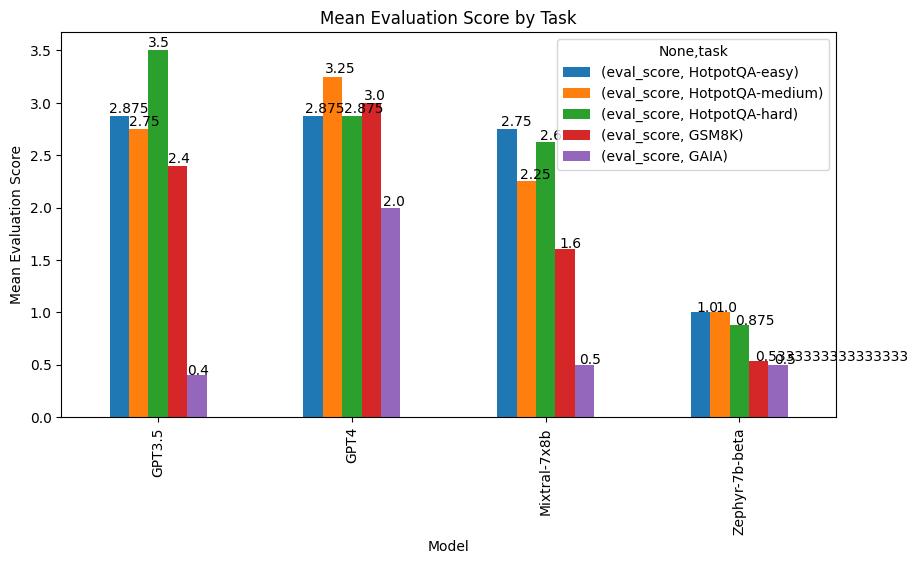

In [42]:
agg_df = (
    result_df.groupby(["agent_name", "task"])
    .agg({"eval_score": "mean"})
    .unstack("task")
)
display(agg_df)

ax = agg_df[
    [("eval_score", "HotpotQA-easy"), ("eval_score", "HotpotQA-medium"), ("eval_score", "HotpotQA-hard"), ("eval_score", "GSM8K"), ("eval_score", "GAIA")]
].plot.bar(
    figsize=(10, 5),
    title="Mean Evaluation Score by Task",
    xlabel="Model",
    ylabel="Mean Evaluation Score",
)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.01, p.get_height() * 1.01))

#### visualizations to make
- avg model score by question difficulty
- count of parsing errors and iteration limit errors

## To-do:
- Generalize evaluation code
- Make evals fully async
- Select 3-5 models to evaluate on
- Run eval
- Write blog post
- Get LangChain PR merged

## Notes

- One of the main challenges with open LLMs is ensuring they adhere to the proper markdown JSON output!
- Another is when they serve as the evaluator, they struggle to handle the default "labeled_criteria" prompt and end up hallucinating. Needs to be modified / simplified.
- I also found that GPT4 actually did pretty poor at judging correctness given the default LangChain prompt!